<a href="https://colab.research.google.com/github/rifqoi/Inacure-Machine-Learning/blob/main/03-ensemble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Load Dataset from Google Drive

In [1]:
import os
from google.colab import drive
drive.mount('/content/drive')
# !unzip  drive/Shareddrives/Bangkit\ Capstone/leaf_datasets.zip -d .

Mounted at /content/drive


# Import Libraries

In [2]:
import re
import os
import zipfile
import random
import shutil
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras import layers, models
from tensorflow.keras.callbacks import EarlyStopping

tf.keras.utils.set_random_seed(42)

from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from shutil import copyfile

# List directories for each datasets

In [6]:
dataset_dir = f"/content/drive/Shareddrives/Bangkit Capstone/Final_Split_Datasets"
train_dir = os.path.join(dataset_dir, "train")
validation_dir = os.path.join(dataset_dir, "validation")
test_dir = os.path.join(dataset_dir, "test")

# List Images

In [ ]:
def list_images():
  classes_dirs = os.listdir(train_dir)
  for folder in classes_dirs:
    train_classes = os.listdir(os.path.join(train_dir, folder))
    validation_classes = os.listdir(os.path.join(validation_dir, folder))
    test_classes = os.listdir(os.path.join(test_dir, folder))
    print(f"{folder}: \n \t{len(train_classes)} train images, {len(validation_classes)} validation images, and {len(test_classes)} test images,  total {len(train_classes) + len(validation_classes) + len(test_classes)} images")
    print()
list_images()

Pepaya: 
 	168 train images, 47 validation images, and 25 test images,  total 240 images

Jambu Biji: 
 	154 train images, 44 validation images, and 23 test images,  total 221 images

Mint: 
 	302 train images, 85 validation images, and 45 test images,  total 432 images

Kelor: 
 	153 train images, 43 validation images, and 23 test images,  total 219 images

Lemon: 
 	151 train images, 42 validation images, and 23 test images,  total 216 images

Bayam Hijau: 
 	206 train images, 58 validation images, and 31 test images,  total 295 images

Mangga: 
 	304 train images, 86 validation images, and 45 test images,  total 435 images

Basil: 
 	103 train images, 29 validation images, and 16 test images,  total 148 images



# Create a model class to prevent code redundancy

In [15]:
class Model:
  def __init__(self, model, config):
    self.config = config
    self.batch_size = self.config['batch_size']
    # self.trainable = self.config['trainable']
    self.epochs = self.config['epochs']
    self.classes= self.config['classes']
    self.input_shape = self.config['input_shape']
    self.base_model = model

  def train_val_generators(self, TRAINING_DIR, VALIDATION_DIR, TEST_DIR, preprocess_input=None):
    train_datagen = ImageDataGenerator(rescale = 1./255.,
                                rotation_range = 25,
                                zoom_range = [0.5, 1.1],
                                width_shift_range=0.15, 
                                shear_range= 0.15,
                                height_shift_range=0.15,
                                preprocessing_function=preprocess_input,
                                horizontal_flip=True,
                                vertical_flip= True,
                                fill_mode='nearest',)
  
    train_generator = train_datagen.flow_from_directory(directory=TRAINING_DIR,
                                                        batch_size=32, 
                                                        seed=42,
                                                        class_mode='sparse',
                                                        target_size=(224, 224))
  
    validation_datagen = ImageDataGenerator(rescale = 1/255,
                                            preprocessing_function=preprocess_input)
  
    validation_generator = validation_datagen.flow_from_directory(directory=VALIDATION_DIR,
                                                                  batch_size=32, 
                                                                  seed=42,
                                                                  class_mode='sparse',
                                                                  target_size=(224, 224))
    test_datagen = ImageDataGenerator(rescale= 1./255.)
  
    test_generator = test_datagen.flow_from_directory(directory=TEST_DIR,
                                                                  batch_size=32,
                                                                  shuffle=False, 
                                                                  seed=42,
                                                                  class_mode='sparse',
                                                                  target_size=(224, 224))

    self.train_generator = train_generator
    self.validation_generator = validation_generator
    self.test_generator = test_generator
    return train_generator, validation_generator, test_generator

  def set_generator(self, train_generator, val_generator, test_generator, ):
    self.train_generator = train_generator
    self.valdation_generator = validation_generator
    self.test_generator = test_generator
  

  def build_model(self, compile_config, custom_layer = None):

    compile_config['metrics'] = [metric.replace("accuracy", "acc") for metric in compile_config['metrics']]

    layers = []
    
    # Append base model to layers_list
    layers.append(self.base_model)

    flatten_layer = tf.keras.layers.Flatten()
    layers.append(flatten_layer)

    if custom_layer is None:
      layers.append(tf.keras.layers.Dense(512, activation='relu'))
    else: 
      for layer in custom_layer:
        layers.append(layer)
    
    prediction_layer = tf.keras.layers.Dense(self.classes, activation='softmax')
    layers.append(prediction_layer)

    self.model = tf.keras.models.Sequential(layers)

    self.model.compile(**compile_config)
    self.model.summary()

    return self.model

  def train(self, model_name, reduce_lr_config=None):
    self.model_name = model_name
    model_filepath = model_name +'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
    model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')
    model_early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)
    callbacks = [model_checkpoint, model_early_stopping]
    if reduce_lr_config is not None:
      reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(**reduce_lr_config)
      callbacks.append(reduce_lr)
    model_history = self.model.fit(self.train_generator, epochs = self.epochs,
                                   validation_data = self.validation_generator,callbacks=callbacks , verbose=1)
    self.history = model_history
    return model_history

  def plot_history(self):
    acc = self.history.history['acc']
    val_acc = self.history.history['val_acc']
    loss = self.history.history['loss']
    val_loss = self.history.history['val_loss']
    
    epochs = range(len(acc))
    
    plt.subplot()
    plt.plot(epochs, acc, 'r', label='Training accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
    plt.title('Training and validation accuracy')
    plt.legend(loc=0)
    plt.figure()
  
    plt.subplot()
    plt.title('Training and validation loss')
    plt.plot(epochs, loss, label='Training Loss')
    plt.plot(epochs, val_loss,  label='Validation Loss')
    plt.legend()
    plt.show()
    
    plt.show()

  def evaluate_model(self):
    evaluate = self.model.evaluate(self.test_generator)
    print('Loss of the model is - ', evaluate[0])
    print('Accuracy of the model is - ', evaluate[1]*100, '%')
  
    classes =  list(self.test_generator.class_indices.keys())
    Y_pred = self.model.predict(self.test_generator)
    y_pred = np.argmax(Y_pred, axis=1)
    
    print(classification_report(self.test_generator.classes, y_pred, target_names=classes))
    print('Confusion Matrix')
    conf_matrix = confusion_matrix(self.test_generator.classes, y_pred)
    df_cm = pd.DataFrame(conf_matrix, index = classes, columns = classes)
    ax = sns.heatmap(df_cm, annot=True, cmap='Blues')
  
    ax.set_title('Seaborn Confusion Matrix with labels\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
  
  def find_best_model(self, weights_dir):
    weights = os.listdir(weights_dir)
    weights = list(filter(lambda x: self.model_name in x, weights))

    best_acc = 0
    best_weight = None
    for weight in weights:
      acc = int(re.search(r"\.(\d+)\.", weight).group(1))
      if best_acc < acc:
        best_acc = acc
        best_weight = weight
    
    self.best_weight = os.path.join(weights_dir, best_weight)
    print(self.best_weight)

  def evaluate_best_model(self, ):
    if self.best_weight is None:
      print("find_best_model dulu cuy")
      return 1
    self.model.load_weights(self.best_weight)
    self.evaluate_model()
  
  def save_best_model(self, target_dir):
    if self.best_weight is None:
      print("find_best_model dulu cuy")
      return 1
    print(f"Copy {self.best_weight} to {target_dir}")
    shutil.copy(self.best_weight, target_dir)
  
  def load_best_model(self, weight_path):
    self.best_weight = weight_path
    self.model.load_weights(self.best_weight)

# VGG16 


## Build Model

In [23]:
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input as vgg16_preprocess_input
config = {
    "batch_size": 32,
    "epochs": 20,
    "classes": 8,
    "input_shape": (224, 224, 3)

}

compile_config = {
    "loss": "sparse_categorical_crossentropy",
    "optimizer": Adam(learning_rate=0.0001),
    "metrics": ["acc"],
}

custom_layer = [
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu')
]

vgg16 = VGG16(weights="imagenet", include_top=False, input_shape=config['input_shape'])
vgg16.trainable = False

vgg16_model = Model(model=vgg16, config=config)
vgg16_model.train_val_generators(train_dir, validation_dir, test_dir, preprocess_input=vgg16_preprocess_input)
vgg16_model.build_model(compile_config, custom_layer=custom_layer)

Found 1518 images belonging to 8 classes.
Found 427 images belonging to 8 classes.
Found 224 images belonging to 8 classes.
Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten_9 (Flatten)         (None, 25088)             0         
                                                                 
 dense_20 (Dense)            (None, 512)               12845568  
                                                                 
 dense_21 (Dense)            (None, 1024)              525312    
                                                                 
 dense_22 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_23 (Dense)            (None, 8)                 8200   

## Train Model

In [24]:
vgg16_model.train(model_name='vgg16')

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 1.2006 - acc: 0.5843 
Epoch 1: val_acc improved from -inf to 0.75644, saving model to vgg16-saved-model-01-acc-0.76.hdf5
48/48 [==============================] - 1219s 25s/step - loss: 1.2006 - acc: 0.5843 - val_loss: 0.6491 - val_acc: 0.7564
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.6150 - acc: 0.7740
Epoch 2: val_acc improved from 0.75644 to 0.83372, saving model to vgg16-saved-model-02-acc-0.83.hdf5
48/48 [==============================] - 226s 5s/step - loss: 0.6150 - acc: 0.7740 - val_loss: 0.4525 - val_acc: 0.8337
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.4506 - acc: 0.8373
Epoch 3: val_acc improved from 0.83372 to 0.88993, saving model to vgg16-saved-model-03-acc-0.89.hdf5
48/48 [==============================] - 222s 5s/step - loss: 0.4506 - acc: 0.8373 - val_loss: 0.3279 - val_acc: 0.8899
Epoch 4/20
48/48 [==============================] - ETA: 0s - loss:

## History

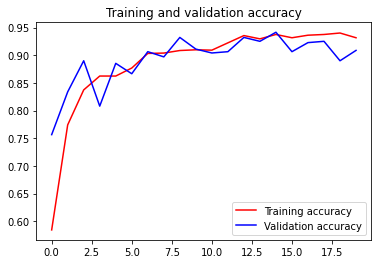

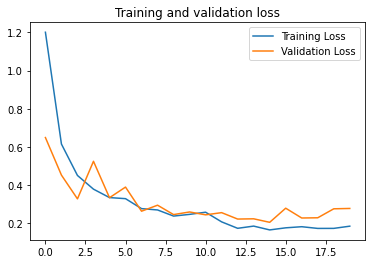

In [25]:
vgg16_model.plot_history()

## Evaluate Model

1/7 [===>..........................] - ETA: 30s - loss: 0.0510 - acc: 1.0000

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


7/7 [==============================] - 130s 21s/step - loss: 0.3834 - acc: 0.8839
Loss of the model is -  0.383413165807724
Accuracy of the model is -  88.39285969734192 %
              precision    recall  f1-score   support

       Basil       1.00      1.00      1.00        16
 Bayam Hijau       0.81      1.00      0.89        29
  Jambu Biji       0.83      0.75      0.79        20
       Kelor       0.69      0.91      0.78        22
       Lemon       0.86      0.78      0.82        23
      Mangga       0.98      0.93      0.95        45
        Mint       0.93      0.84      0.88        45
      Pepaya       1.00      0.83      0.91        24

    accuracy                           0.88       224
   macro avg       0.89      0.88      0.88       224
weighted avg       0.90      0.88      0.89       224

Confusion Matrix


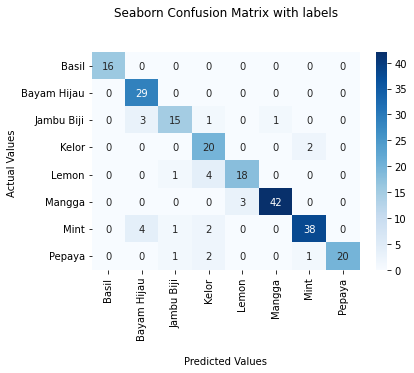

In [26]:
vgg16_model.evaluate_model()

In [27]:
vgg16_model.model_name = 'vgg16'
vgg16_model.find_best_model('.')

./vgg16-saved-model-15-acc-0.94.hdf5


## Evaluate Best Model

1/7 [===>..........................] - ETA: 29s - loss: 0.0174 - acc: 1.0000

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


7/7 [==============================] - 23s 3s/step - loss: 0.2628 - acc: 0.9107
Loss of the model is -  0.262822687625885
Accuracy of the model is -  91.07142686843872 %
              precision    recall  f1-score   support

       Basil       1.00      1.00      1.00        16
 Bayam Hijau       0.78      0.97      0.86        29
  Jambu Biji       0.89      0.80      0.84        20
       Kelor       0.90      0.86      0.88        22
       Lemon       0.91      0.91      0.91        23
      Mangga       0.98      0.96      0.97        45
        Mint       0.91      0.89      0.90        45
      Pepaya       0.95      0.88      0.91        24

    accuracy                           0.91       224
   macro avg       0.92      0.91      0.91       224
weighted avg       0.92      0.91      0.91       224

Confusion Matrix


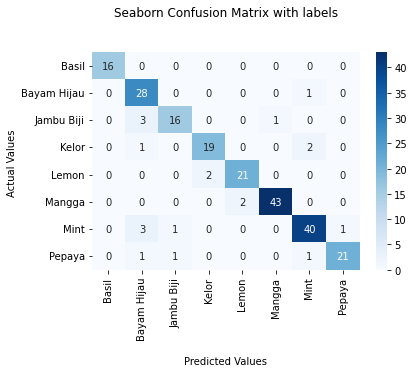

In [28]:
vgg16_model.evaluate_best_model()

# InceptionV3 (sucks)

## Build Model

In [32]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input as iv3_preprocess_input

config = {
    "batch_size": 32,
    "epochs": 20,
    "classes": 8,
    "input_shape": (224, 224, 3)

}

compile_config = {
    "loss": "sparse_categorical_crossentropy",
    "optimizer": Adam(learning_rate=0.0001),
    "metrics": ["accuracy"],
}

inceptionv3  = InceptionV3(weights="imagenet", include_top=False, input_shape=config['input_shape'],)
for layer in inceptionv3.layers[:249]:
   layer.trainable = False
for layer in inceptionv3.layers[249:]:
   layer.trainable = True

custom_layer = [
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu')
]

iv3_model = Model(model=inceptionv3, config=config)
iv3_model.train_val_generators(train_dir, validation_dir, test_dir, preprocess_input=iv3_preprocess_input)
iv3_model.build_model(compile_config, custom_layer=custom_layer)

Found 1518 images belonging to 8 classes.
Found 427 images belonging to 8 classes.
Found 224 images belonging to 8 classes.
Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 flatten_12 (Flatten)        (None, 51200)             0         
                                                                 
 dropout_2 (Dropout)         (None, 51200)             0         
                                                                 
 dense_33 (Dense)            (None, 512)               26214912  
                                                                 
 dense_34 (Dense)            (None, 1024)              525312    
                                                                 
 dense_35 (Dense)            (None, 1024)              104960

## Train Model

In [33]:
reduce_lr_config = {
    'monitor': 'val_loss',
    'factor': 0.05, 
    'patience':5, 
    'min_lr': 0.000002
}
iv3_model.train('inceptionv3', reduce_lr_config=reduce_lr_config)

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 1.5567 - acc: 0.3926
Epoch 1: val_acc improved from -inf to 0.30445, saving model to inceptionv3-saved-model-01-acc-0.30.hdf5
48/48 [==============================] - 235s 5s/step - loss: 1.5567 - acc: 0.3926 - val_loss: 1.7362 - val_acc: 0.3044 - lr: 1.0000e-04
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 1.2836 - acc: 0.4947
Epoch 2: val_acc improved from 0.30445 to 0.48478, saving model to inceptionv3-saved-model-02-acc-0.48.hdf5
48/48 [==============================] - 226s 5s/step - loss: 1.2836 - acc: 0.4947 - val_loss: 1.3601 - val_acc: 0.4848 - lr: 1.0000e-04
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 1.1994 - acc: 0.5244
Epoch 3: val_acc improved from 0.48478 to 0.49180, saving model to inceptionv3-saved-model-03-acc-0.49.hdf5
48/48 [==============================] - 227s 5s/step - loss: 1.1994 - acc: 0.5244 - val_loss: 1.2302 - val_acc: 0.4918 - lr: 1.0000e-04
E

## History

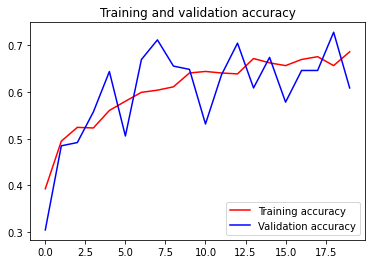

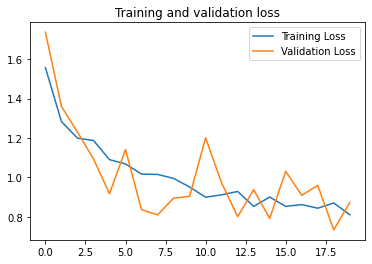

In [34]:
iv3_model.plot_history()

## Evaluate Model

1/7 [===>..........................] - ETA: 29s - loss: 11.1516 - acc: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


7/7 [==============================] - 24s 3s/step - loss: 8.4691 - acc: 0.1027
Loss of the model is -  8.469086647033691
Accuracy of the model is -  10.26785746216774 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Basil       0.00      0.00      0.00        16
 Bayam Hijau       0.00      0.00      0.00        29
  Jambu Biji       0.00      0.00      0.00        20
       Kelor       0.10      0.95      0.17        22
       Lemon       0.00      0.00      0.00        23
      Mangga       0.00      0.00      0.00        45
        Mint       0.00      0.00      0.00        45
      Pepaya       0.50      0.08      0.14        24

    accuracy                           0.10       224
   macro avg       0.07      0.13      0.04       224
weighted avg       0.06      0.10      0.03       224

Confusion Matrix


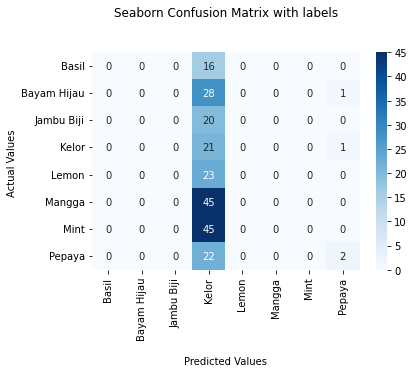

In [35]:
iv3_model.evaluate_model()

## Evaluate Best Model

./inceptionv3-saved-model-19-acc-0.73.hdf5
1/7 [===>..........................] - ETA: 29s - loss: 11.4252 - acc: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


7/7 [==============================] - 23s 3s/step - loss: 8.7554 - acc: 0.1295
Loss of the model is -  8.755419731140137
Accuracy of the model is -  12.94642835855484 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Basil       0.00      0.00      0.00        16
 Bayam Hijau       0.00      0.00      0.00        29
  Jambu Biji       0.00      0.00      0.00        20
       Kelor       0.10      0.86      0.17        22
       Lemon       0.00      0.00      0.00        23
      Mangga       0.00      0.00      0.00        45
        Mint       0.00      0.00      0.00        45
      Pepaya       0.37      0.42      0.39        24

    accuracy                           0.13       224
   macro avg       0.06      0.16      0.07       224
weighted avg       0.05      0.13      0.06       224

Confusion Matrix


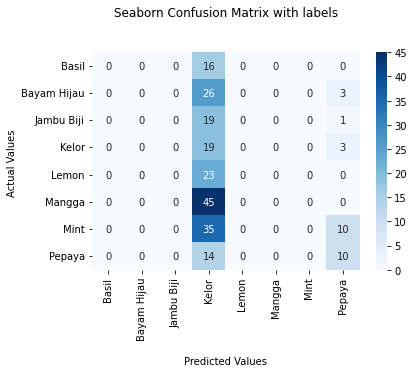

In [36]:
iv3_model.model_name = 'inceptionv3'
iv3_model.find_best_model('.')
iv3_model.evaluate_best_model()

In [ ]:
target_dir = '/content/drive/Shareddrives/Bangkit Capstone/Best Model'
iv3_model.save_best_model(target_dir=target_dir)

Copy ./inceptionv3-saved-model-06-acc-0.68.hdf5 to /content/drive/Shareddrives/Bangkit Capstone/Best Model


# ResNet50

## Build Model

In [38]:
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input
config = {
    "batch_size": 32,
    "trainable": False,
    "epochs": 20,
    "classes": 8,
    "input_shape": (224, 224, 3)

}

compile_config = {
    "loss": "sparse_categorical_crossentropy",
    "optimizer": Adam(lr=1e-4),
    "metrics": ["accuracy"],
}

custom_layer = [
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu')
]

resnet50 = ResNet50(weights="imagenet", include_top=False, input_shape=config['input_shape'],)
resnet50.trainable = False
resnet50_model = Model(model=resnet50, config=config)
resnet50_model.train_val_generators(train_dir, validation_dir, test_dir, preprocess_input=resnet50_preprocess_input)
resnet50_model.build_model(compile_config, custom_layer=custom_layer)

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


94781440/94765736 [==============================] - 1s 0us/step
Found 1518 images belonging to 8 classes.
Found 427 images belonging to 8 classes.
Found 224 images belonging to 8 classes.
Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten_13 (Flatten)        (None, 100352)            0         
                                                                 
 dense_37 (Dense)            (None, 512)               51380736  
                                                                 
 dense_38 (Dense)            (None, 1024)              525312    
                                                                 
 dense_39 (Dense)            (None, 1024)              1049600   
                                                              

## Train Model

In [39]:
reduce_lr_config = {
    'monitor': 'val_loss',
    'factor': 0.05, 
    'patience':5, 
    'min_lr': 0.000002
}
resnet50_model.train('resnet50', reduce_lr_config=reduce_lr_config)

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 1.8786 - acc: 0.3142
Epoch 1: val_acc improved from -inf to 0.42623, saving model to resnet50-saved-model-01-acc-0.43.hdf5
48/48 [==============================] - 234s 5s/step - loss: 1.8786 - acc: 0.3142 - val_loss: 1.5219 - val_acc: 0.4262 - lr: 1.0000e-04
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 1.6161 - acc: 0.3748
Epoch 2: val_acc did not improve from 0.42623
48/48 [==============================] - 223s 5s/step - loss: 1.6161 - acc: 0.3748 - val_loss: 1.5354 - val_acc: 0.4239 - lr: 1.0000e-04
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 1.4853 - acc: 0.4130
Epoch 3: val_acc improved from 0.42623 to 0.44028, saving model to resnet50-saved-model-03-acc-0.44.hdf5
48/48 [==============================] - 225s 5s/step - loss: 1.4853 - acc: 0.4130 - val_loss: 1.4317 - val_acc: 0.4403 - lr: 1.0000e-04
Epoch 4/20
48/48 [==============================] - ETA: 0s - loss: 1

## History

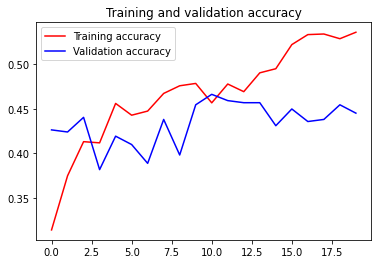

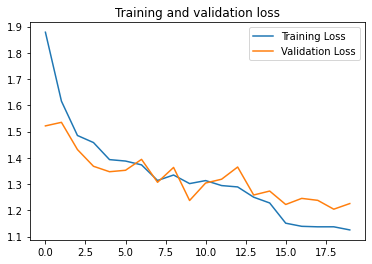

In [42]:
resnet50_model.plot_history()

## Evaluate Model

1/7 [===>..........................] - ETA: 31s - loss: 1.6835 - acc: 0.0938

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


7/7 [==============================] - 24s 3s/step - loss: 1.3344 - acc: 0.4554
Loss of the model is -  1.33437979221344
Accuracy of the model is -  45.53571343421936 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Basil       0.00      0.00      0.00        16
 Bayam Hijau       0.23      0.10      0.14        29
  Jambu Biji       0.00      0.00      0.00        20
       Kelor       0.26      0.77      0.39        22
       Lemon       0.00      0.00      0.00        23
      Mangga       0.60      1.00      0.75        45
        Mint       0.51      0.51      0.51        45
      Pepaya       0.54      0.58      0.56        24

    accuracy                           0.46       224
   macro avg       0.27      0.37      0.29       224
weighted avg       0.34      0.46      0.37       224

Confusion Matrix


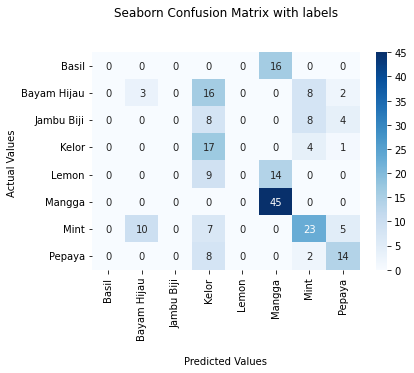

In [40]:
resnet50_model.evaluate_model()

## Evaluate Best Model

./resnet50-saved-model-11-acc-0.47.hdf5
1/7 [===>..........................] - ETA: 31s - loss: 1.8790 - acc: 0.0000e+00

/usr/local/lib/python3.7/dist-packages/PIL/Image.py:960: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  "Palette images with Transparency expressed in bytes should be "


7/7 [==============================] - 25s 3s/step - loss: 1.3031 - acc: 0.4554
Loss of the model is -  1.3030669689178467
Accuracy of the model is -  45.53571343421936 %


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

       Basil       0.00      0.00      0.00        16
 Bayam Hijau       0.00      0.00      0.00        29
  Jambu Biji       0.00      0.00      0.00        20
       Kelor       0.24      0.59      0.34        22
       Lemon       0.00      0.00      0.00        23
      Mangga       0.60      1.00      0.75        45
        Mint       0.52      0.53      0.53        45
      Pepaya       0.45      0.83      0.59        24

    accuracy                           0.46       224
   macro avg       0.23      0.37      0.28       224
weighted avg       0.30      0.46      0.35       224

Confusion Matrix


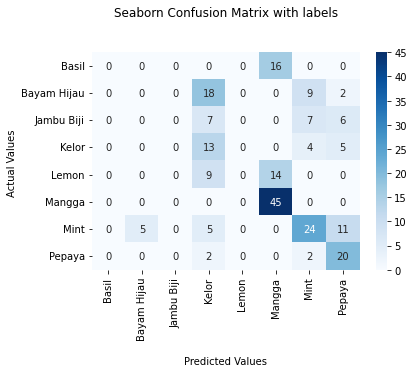

In [41]:
resnet50_model.model_name = 'resnet50'
resnet50_model.find_best_model('.')
resnet50_model.evaluate_best_model()

In [43]:
target_dir = '/content/drive/Shareddrives/Bangkit Capstone/Best Model'
resnet50_model.save_best_model(target_dir=target_dir)

Copy ./resnet50-saved-model-11-acc-0.47.hdf5 to /content/drive/Shareddrives/Bangkit Capstone/Best Model


# VGG19

## Build Model

In [46]:
from tensorflow.keras.applications.vgg19 import VGG19
from tensorflow.keras.applications.vgg19 import preprocess_input as vgg19_preprocess_input

config = {
    "batch_size": 32,
    "epochs": 20,
    "classes": 8,
    "input_shape": (224, 224, 3)

}

compile_config = {
    "loss": "sparse_categorical_crossentropy",
    "optimizer": Adam(learning_rate=0.0001),
    "metrics": ["accuracy"],
}
vgg19 = VGG19(
        include_top=False,
        weights='imagenet',
        input_shape=config['input_shape'],
)

custom_layer = [
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(1024, activation='relu'),
]

vgg19.trainable = False
vgg19_model = Model(model=vgg19, config=config)
vgg19_model.train_val_generators(train_dir, validation_dir, test_dir, preprocess_input=vgg19_preprocess_input)
vgg19_model.build_model(compile_config, custom_layer)

Found 1518 images belonging to 8 classes.
Found 427 images belonging to 8 classes.
Found 224 images belonging to 8 classes.
Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 7, 7, 512)         20024384  
                                                                 
 flatten_15 (Flatten)        (None, 25088)             0         
                                                                 
 dense_45 (Dense)            (None, 512)               12845568  
                                                                 
 dense_46 (Dense)            (None, 1024)              525312    
                                                                 
 dense_47 (Dense)            (None, 1024)              1049600   
                                                                 
 dense_48 (Dense)            (None, 8)                 8200  

## Train Model

In [ ]:
reduce_lr_config = {
    'monitor': 'val_loss',
    'factor': 0.05, 
    'patience':5, 
    'min_lr': 0.000002
}
vgg19_model.train('vgg19', reduce_lr_config=reduce_lr_config)

Epoch 1/20
48/48 [==============================] - ETA: 0s - loss: 1.3160 - acc: 0.5138
Epoch 1: val_acc improved from -inf to 0.70492, saving model to vgg19-saved-model-01-acc-0.70.hdf5
48/48 [==============================] - 229s 5s/step - loss: 1.3160 - acc: 0.5138 - val_loss: 0.8230 - val_acc: 0.7049 - lr: 1.0000e-04
Epoch 2/20
48/48 [==============================] - ETA: 0s - loss: 0.7185 - acc: 0.7431
Epoch 2: val_acc improved from 0.70492 to 0.83607, saving model to vgg19-saved-model-02-acc-0.84.hdf5
48/48 [==============================] - 226s 5s/step - loss: 0.7185 - acc: 0.7431 - val_loss: 0.4913 - val_acc: 0.8361 - lr: 1.0000e-04
Epoch 3/20
48/48 [==============================] - ETA: 0s - loss: 0.5775 - acc: 0.7839
Epoch 3: val_acc improved from 0.83607 to 0.83841, saving model to vgg19-saved-model-03-acc-0.84.hdf5
48/48 [==============================] - 224s 5s/step - loss: 0.5775 - acc: 0.7839 - val_loss: 0.4422 - val_acc: 0.8384 - lr: 1.0000e-04
Epoch 4/20
48/48 [=

## History

In [ ]:
vgg19_model.plot_history()

## Evaluate Model

In [ ]:
vgg19_model.evaluate_model()

## Evaluate Best Model

In [ ]:
vgg19_model.model_name = 'vgg19'
vgg19_model.find_best_model('.')
vgg19_model.evaluate_best_model()

In [ ]:
target_dir = '/content/drive/Shareddrives/Bangkit Capstone/Best Model'
vgg19_model.save_best_model(target_dir=target_dir)

In [ ]:
def load_image(img_path, show=False):

    img = load_img(img_path, target_size=(224, 224))
    img_tensor = img_to_array(img)                    # (height, width, channels)
    img_tensor = np.expand_dims(img_tensor, axis=0)         # (1, height, width, channels), add a dimension because the model expects this shape: (batch_size, height, width, channels)
    img_tensor /= 255.                                      # imshow expects values in the range [0, 1]

    if show:
        plt.imshow(img_tensor[0])                           
        plt.axis('off')
        plt.show()

    return img_tensor

In [ ]:
!wget https://media.discordapp.net/attachments/971451202267119678/977480585750667294/IMG20220521145825.jpg -O daun8.jpg

--2022-05-29 12:36:31--  https://media.discordapp.net/attachments/971451202267119678/977480585750667294/IMG20220521145825.jpg
Resolving media.discordapp.net (media.discordapp.net)... 162.159.128.232, 162.159.129.232, 162.159.130.232, ...
Connecting to media.discordapp.net (media.discordapp.net)|162.159.128.232|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2433187 (2.3M) [image/jpeg]
Saving to: ‘daun8.jpg’

daun8.jpg           100%[===================>]   2.32M  --.-KB/s    in 0.03s   

2022-05-29 12:36:31 (79.8 MB/s) - ‘daun8.jpg’ saved [2433187/2433187]



In [ ]:
model = vgg19_model.model
label_map = (train_generator.class_indices)
label_map = {v: k for k, v in label_map.items()}
image_path ='daun8.jpg'
image = load_image(image_path, show=True)
predict = model.predict(image)
print(label_map[np.argmax(model.predict(image))])
predicted_list = [ele * 100 for ele in predict.flatten()]

for idx, ele in enumerate(predicted_list):
  print(f"{label_map[idx]}: {ele}")

In [ ]:
train_generator.class_indices

In [ ]:
import cv2
from google.colab.patches import cv2_imshow
img =  cv2.imread('/istockphoto-584504750-1024x1024.jpg')
hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)

# find the green color 
mask_green = cv2.inRange(hsv, (36,0,0), (86,255,255))
# find the brown color
mask_brown = cv2.inRange(hsv, (8, 60, 20), (30, 255, 200))
# find the yellow color in the leaf
mask_yellow = cv2.inRange(hsv, (21, 39, 64), (40, 255, 255))

# find any of the three colors(green or brown or yellow) in the image
mask = cv2.bitwise_or(mask_green, mask_brown)
mask = cv2.bitwise_or(mask, mask_yellow)

# Bitwise-AND mask and original image
res = cv2.bitwise_and(img,img, mask= mask)

cv2_imshow(img)
cv2_imshow(res)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
train_generator.class_indices

{'Bayam Hijau': 0,
 'Jahe': 1,
 'Jambu Biji': 2,
 'Jeruk Purut': 3,
 'Kelor': 4,
 'Kersen': 5,
 'Lemon': 6,
 'Lengkuas': 7,
 'Mint': 8,
 'Nangka': 9,
 'Pepaya': 10}